Checking for missing values...
Platform                  0
Post ID                   0
Post Type                 0
Post Content              0
Post Timestamp            0
Likes                     0
Comments                  0
Shares                    0
Impressions               0
Reach                     0
Engagement Rate           0
Audience Age              0
Audience Gender           0
Audience Location         0
Audience Interests        0
Campaign ID           79868
Sentiment             50100
Influencer ID         90006
dtype: int64
Sentiment Counts:
Sentiment
2    353
0    340
1    320
Name: count, dtype: int64
Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2957 - loss: 1.0987 - val_accuracy: 0.3059 - val_loss: 1.1004
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3548 - loss: 1.0992 - val_accuracy: 0.3000 - val_loss: 1.1004
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3137 - loss: 1.1011 - val_accuracy: 0.3059 - val

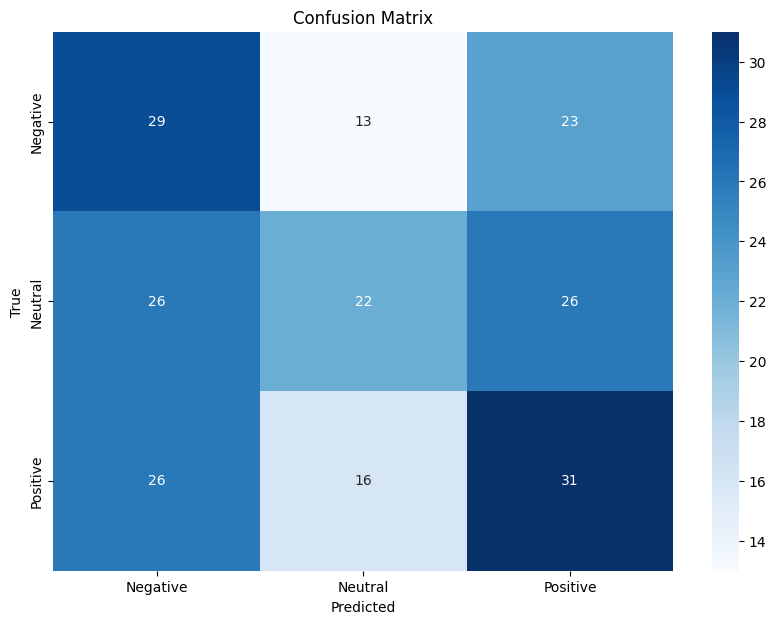

Confusion Matrix for Negative:
[[95 52]
 [36 29]]


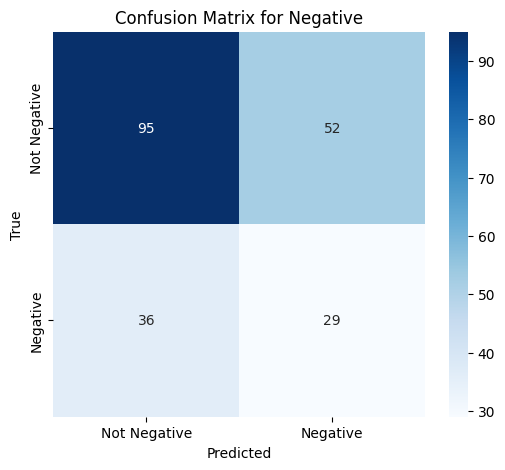

Confusion Matrix for Neutral:
[[109  29]
 [ 52  22]]


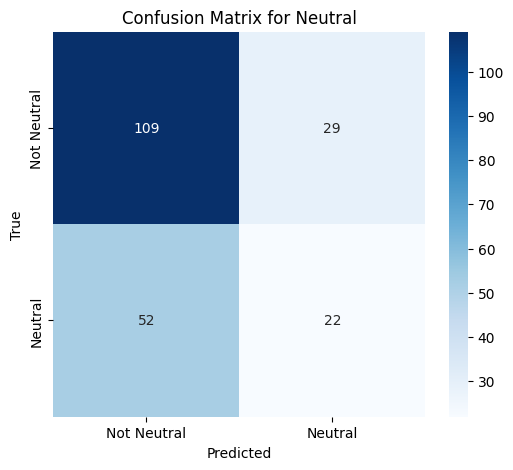

Confusion Matrix for Positive:
[[90 49]
 [42 31]]


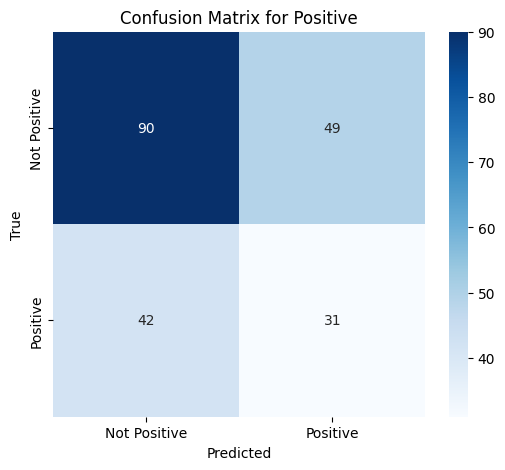

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import multiprocessing
import os

# Utilize all processor threads
os.environ['OMP_NUM_THREADS'] = str(multiprocessing.cpu_count())

# Load the data
data = pd.read_csv('archive (1)\\social_media.csv')

# Check for missing values
print("Checking for missing values...")
missing_values = data.isnull().sum()
print(missing_values)

# Handling missing values
data = data.dropna()

# Drop unnecessary columns and keep only 'Sentiment' and 'Post Content'
data = data[['Sentiment', 'Post Content']]

# Assign numeric values to sentiments
sentiment_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}
data['Sentiment'] = data['Sentiment'].map(sentiment_mapping)

# Verify the sentiment counts
print("Sentiment Counts:")
sentiment_counts = data['Sentiment'].value_counts()
print(sentiment_counts)

# Define features and target
X = data['Post Content']
y = data['Sentiment']

# Feature Engineering
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Using n-grams
X_tfidf = vectorizer.fit_transform(X)

# Balancing the Dataset using SMOTE
smote = SMOTE(random_state=42)
X_tfidf_res, y_res = smote.fit_resample(X_tfidf, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_res, y_res, test_size=0.2, random_state=42)

# Define the model with a more complex architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model with a smaller learning rate and different optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=600, restore_best_weights=True)

# Ensure consistent input shapes
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

# Train the model
history = model.fit(X_train_array, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_array), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:")
print(report)

# Plotting the overall confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Create one-vs-all confusion matrices for each sentiment
sentiments = ['Negative', 'Neutral', 'Positive']

for i, sentiment in enumerate(sentiments):
    y_test_bin = (y_test == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    
    cm_sentiment = confusion_matrix(y_test_bin, y_pred_bin)
    print(f"Confusion Matrix for {sentiment}:")
    print(cm_sentiment)
    
    # Plotting the confusion matrix for each sentiment
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_sentiment, annot=True, fmt='d', cmap='Blues', xticklabels=['Not ' + sentiment, sentiment], yticklabels=['Not ' + sentiment, sentiment])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {sentiment}')
    plt.show()

